# Part 2A: Parallel HDF5

Goals:
------

 * Understand the different options (versions) of the HDF5 library. 
 * Understand the need to know which instance of the HDF5 library h5py and/or pytables is linked to.
 * Explore Parallel HDF5 in h5py
 * Explore Single Reader Multiple Writer (SMWR) mode of HDF5 1.10 in h5py

## About concurrent reading and writing:

### Concurrent reading:
 * When `libhdf5` is compiled with `thread safety` enabled, there is an internal locking mechanism that serialises reads at the `libhdf5` level. Thread safety does result in better multi-core performance.
 * No thread-safety support on Windows.
 * Reading from separate processes (`multiprocessing`) is fine, but file cannot be open for writing.

### Concurrent writing:
 * MPI: Needs `libhdf5` compiled with `parallel HDF5` enabled. Supported in `h5py`.  Not supported in `pytables`.
 * multiprocessing: Writing to temp files and collecting afterwards. 
 * multiprocessing: Writing to a single file and provide your own locking mechanism.
 
 
### Single writer, multiple reader (SWMR)
 * From `HDF5 >= 1.10` supported in `h5py>=2.5`. Not supported in `pytables`. 

## Find your `libhdf5` settings

Let's check the configuration of the installed HDF5 library.

Multiple instances of the HDF5 library may be installed on a system. Let's find which instance we are using.

The HDF5 configuration is summarised in a text file `libhdf5.settings`. Let's find it.

### h5cc

`h5cc` is a wrapper script around `cc` that can print `libhdf5.settings`. 

In [6]:
!h5cc -showconfig

	    SUMMARY OF THE HDF5 CONFIGURATION

General Information:
-------------------
		   HDF5 Version: 1.8.18
		  Configured on: Wed May 31 22:18:44 UTC 2017
		  Configured by: root@2432844d2dde
		 Configure mode: production
		    Host system: x86_64-unknown-linux-gnu
	      Uname information: Linux 2432844d2dde 3.13.0-119-generic #166-Ubuntu SMP Wed May 3 12:18:55 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux
		       Byte sex: little-endian
		      Libraries: static, shared
	     Installation point: /home/vagrant/miniconda3

Compiling Options:
------------------
               Compilation Mode: production
                     C Compiler: /opt/rh/devtoolset-2/root/usr/bin/gcc ( gcc (GCC) 4.8.2 20140120 )
                         CFLAGS:  -m64
                      H5_CFLAGS: -std=c99 -pedantic -Wall -Wextra -Wundef -Wshadow -Wpointer-arith -Wbad-function-cast -Wcast-qual -Wcast-align -Wwrite-strings -Wconversion -Waggregate-return -Wstrict-prototypes -Wmissing-prototypes -Wmissing-declarations

Beware: The jupyter notebook may not be in (is probalby not in) the same environment as the current running kernel.

### Find your libhdf5 location

In [14]:
import h5py
h5py.__file__

'/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/__init__.py'

In [15]:
!find /home/vagrant/miniconda3/lib/ | grep hdf5.settings

/home/vagrant/miniconda3/lib/libhdf5.settings


In [21]:
!ls /home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/*.so

/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/_conv.cpython-36m-x86_64-linux-gnu.so
/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/defs.cpython-36m-x86_64-linux-gnu.so
/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/_errors.cpython-36m-x86_64-linux-gnu.so
/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/h5ac.cpython-36m-x86_64-linux-gnu.so
/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/h5a.cpython-36m-x86_64-linux-gnu.so
/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/h5.cpython-36m-x86_64-linux-gnu.so
/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/h5d.cpython-36m-x86_64-linux-gnu.so
/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/h5ds.cpython-36m-x86_64-linux-gnu.so
/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/h5f.cpython-36m-x86_64-linux-gnu.so
/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/h5fd.cpython-36m-x86_64-linux-gnu.so
/home/vagrant/miniconda3/lib/python3.6/site-package

In [24]:
!ldd /home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/h5g*.so 

	linux-vdso.so.1 =>  (0x00007ffddbdd4000)
	libhdf5.so.10 => /home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/../../../libhdf5.so.10 (0x00007f00381a5000)
	libhdf5_hl.so.10 => /home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/../../../libhdf5_hl.so.10 (0x00007f0037f85000)
	libpython3.6m.so.1.0 => /home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/../../../libpython3.6m.so.1.0 (0x00007f0037a80000)
	libpthread.so.0 => /lib/x86_64-linux-gnu/libpthread.so.0 (0x00007f0037862000)
	libc.so.6 => /lib/x86_64-linux-gnu/libc.so.6 (0x00007f003749a000)
	librt.so.1 => /lib/x86_64-linux-gnu/librt.so.1 (0x00007f0037292000)
	libz.so.1 => /home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/../../.././libz.so.1 (0x00007f003707c000)
	libdl.so.2 => /lib/x86_64-linux-gnu/libdl.so.2 (0x00007f0036e78000)
	libm.so.6 => /lib/x86_64-linux-gnu/libm.so.6 (0x00007f0036b72000)
	libutil.so.1 => /lib/x86_64-linux-gnu/libutil.so.1 (0x00007f003696f000)
	/lib64/ld-linux-x86-64.so.2 (0x00007f00

In [25]:
!cat /home/vagrant/miniconda3/lib/libhdf5.settings

	    SUMMARY OF THE HDF5 CONFIGURATION

General Information:
-------------------
		   HDF5 Version: 1.8.18
		  Configured on: Wed May 31 22:18:44 UTC 2017
		  Configured by: root@2432844d2dde
		 Configure mode: production
		    Host system: x86_64-unknown-linux-gnu
	      Uname information: Linux 2432844d2dde 3.13.0-119-generic #166-Ubuntu SMP Wed May 3 12:18:55 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux
		       Byte sex: little-endian
		      Libraries: static, shared
	     Installation point: /home/vagrant/miniconda3

Compiling Options:
------------------
               Compilation Mode: production
                     C Compiler: /opt/rh/devtoolset-2/root/usr/bin/gcc ( gcc (GCC) 4.8.2 20140120 )
                         CFLAGS:  -m64
                      H5_CFLAGS: -std=c99 -pedantic -Wall -Wextra -Wundef -Wshadow -Wpointer-arith -Wbad-function-cast -Wcast-qual -Wcast-align -Wwrite-strings -Wconversion -Waggregate-return -Wstrict-prototypes -Wmissing-prototypes -Wmissing-declarations

-------------------------------------------------------------

## Exercise

Goal: Become aware of `libhdf5` instances and configurations.

Time: 5 minutes.

* Find the instance of `libhdf5` that `h5py` (or `pytables`) is (runtime) linked to.
* Study the contents of the file `libhdf5.settings` (or `hdf5.settings`)

SOLUTION remove:

HDF5 1.8.17 ---> CVEs from 2016

Thread-safety and parallel HDF5 (MPI) are mutally exclusive options. On Linux/OSX threadsafety is usually ON. On Windows it is usually OFF. Check your installation.



# Parallel HDF5 using h5py (MPI)

In [1]:
import mpi4py

In [2]:
mpi4py.__file__

'/home/vagrant/miniconda3/envs/hdf5-mpi/lib/python2.7/site-packages/mpi4py/__init__.pyc'

In [8]:
#!cat /home/vagrant/miniconda3/envs/hdf5-mpi/lib/libhdf5.settings

__MPI example from the h5py docs:__

Open an HDF5 file, create a dataset (0, 0, 0, 0) and store

```
dataset[process_id] = process_id
```
    

In [4]:
from mpi4py import MPI  
import h5py

rank = MPI.COMM_WORLD.rank  # The process ID (integer 0-3 for 4-process run)

# This changes metadata (creates a dataset): Collective operation. 
# All processes must do this.
f = h5py.File('parallel_test.hdf5', 'w', driver='mpio', comm=MPI.COMM_WORLD)

# independent operation: Different for each process.
dset = f.create_dataset('test', (4,), dtype='i')
dset[rank] = rank

f.close()

In [88]:
!h5dump parallel_test.hdf5

HDF5 "parallel_test.hdf5" {
GROUP "/" {
   DATASET "test" {
      DATATYPE  H5T_STD_I32LE
      DATASPACE  SIMPLE { ( 4 ) / ( 4 ) }
      DATA {
      (0): 0, 0, 0, 0
      }
   }
}
}


Obviously, inside the notebook, this does not run in parallel.

We need to use `mpiexec` to start parallel processes:

In [98]:
!mpiexec -n 4 python demo_mpi.py

Traceback (most recent call last):
  File "demo_mpi.py", line 2, in <module>
    from mpi4py import MPI
ModuleNotFoundError: No module named 'mpi4py'
Traceback (most recent call last):
  File "demo_mpi.py", line 2, in <module>
    from mpi4py import MPI
ModuleNotFoundError: No module named 'mpi4py'
Traceback (most recent call last):
  File "demo_mpi.py", line 2, in <module>
    from mpi4py import MPI
ModuleNotFoundError: No module named 'mpi4py'
Traceback (most recent call last):
  File "demo_mpi.py", line 2, in <module>
    from mpi4py import MPI
ModuleNotFoundError: No module named 'mpi4py'


In [5]:
!h5dump parallel_test.hdf5

HDF5 "parallel_test.hdf5" {
GROUP "/" {
   DATASET "test" {
      DATATYPE  H5T_STD_I32LE
      DATASPACE  SIMPLE { ( 4 ) / ( 4 ) }
      DATA {
      (0): 0, 0, 0, 0
      }
   }
}
}


# Single writer, multiple reader (SWMR) 

In [76]:
from __future__ import print_function

import numpy as np
import h5py

SIZE = 10

def mandelbrot(a):
    """very slow mandelbrot calculation"""
    z = 0
    for n in range(1, 200):
        z = z**2 + a
        if abs(z) > 2:
            return n
    return 0
 

X = np.linspace(-2, .5, SIZE)
Y = np.linspace(-1,  1, SIZE)
Z = np.zeros((SIZE,))

f = h5py.File('mandel.h5', 'w', libver='latest')
f.swmr_mode = True
dset = f.create_dataset('/m', shape=(0, SIZE), dtype='i', maxshape=(SIZE, SIZE))
dset.attrs['size'] = SIZE

for row, y in enumerate(Y):
    print (row, "of", len(Y))
    dset.resize(row+1, axis=0)
    for col, x in enumerate(X):
        Z[col] = mandelbrot(x + 1j * y)
    dset[row:] = Z
    f.flush()

f.close()

0 of 10
1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10


In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

1000 1000


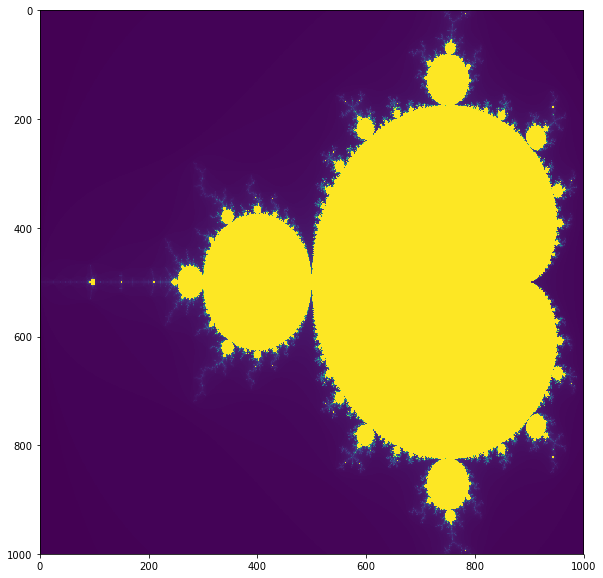

In [90]:
with h5py.File('mandel.h5', 'r', libver='latest', swmr=True) as f:
    dset = f['/m']
    size = dset.attrs['size']
    rows = len(dset)
    plt.figure(figsize=(10, 10))
    print (rows, size)                   
    plt.imshow(dset[:])

# Low level API

h5py exposes the HDF5 low level API, which can be mixed with the high level interface.

In [3]:
import h5py
import numpy as np

In [90]:
f = h5py.File('dataset.h5', 'w')
f['/data'] = np.arange(100, dtype=np.int8)
f['/data'][:]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int8)

### H5Dget_storage_size() : get size of dataset on disk
```
H5Dget_storage_size
hsize_t H5Dget_storage_size( hid_t dataset_id )
```
HDF5 API reference: https://support.hdfgroup.org/HDF5/doc/RM/RM_H5D.html#Dataset-GetStorageSize

h5py API docs: http://api.h5py.org/h5d.html

In [92]:
dset = f['data']
dset

<HDF5 dataset "data": shape (100,), type "|i1">

In [93]:
dset.id

The `DatasetID` class is a proxy object that wrap the H5D API in the Cython module `h5d.pyx`:


In [94]:
dset.id.get_storage_size()

100L

In [95]:
f.close()

# H5Lcreate_external

Create an external link in a HDF5 file.

link `link.h5:/links/data` to `dataset.h5:/data`

In [75]:
f2 = h5py.File('link.h5', 'w')

In [76]:
g = f2.create_group('links')

In [79]:
group_id = g.id
group_id

Or using the low level API:

```
H5GOpen
hid_t H5Gopen( hid_t loc_id, const char *name )
```

https://support.hdfgroup.org/HDF5/doc/RM/RM_H5G.html#Group-Open

http://api.h5py.org/h5g.html

In [80]:
h5py.h5g.open(f2.id, b'links')

note the bytestrings in the call to the low level API function.

Low level API:

```
H5Lcreate_external

herr_t H5Lcreate_external( const char *target_file_name, const char *target_obj_name, hid_t link_loc_id, const char *link_name, hid_t lcpl_id, hid_t lapl_id )
```

https://support.hdfgroup.org/HDF5/doc/RM/RM_H5L.html#Link-CreateExternal

http://api.h5py.org/h5l.html#module-h5py.h5l



In [81]:
group_id.links.create_external(b'data', b'dataset.h5', b'/data')

In [82]:
g, list(g)

(<HDF5 group "/links" (1 members)>, [u'data'])

In [83]:
f2['/links/data']

<HDF5 dataset "data": shape (100,), type "|i1">

In [84]:
f2['/links/data'][:]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int8)

In [85]:
!rm dataset.h5

In [86]:
f2['/links/data']

KeyError: "Unable to open object (Unable to open external file, external link file name = 'dataset.h5', temp_file_name = 'dataset.h5')"

In [87]:
f2.close()

In [88]:
!h5dump link.h5

HDF5 "link.h5" {
GROUP "/" {
   GROUP "links" {
      EXTERNAL_LINK "data" {
         TARGETFILE "dataset.h5"
         TARGETPATH "/data"
      }
   }
}
}


In [96]:
!h5dump dataset.h5

HDF5 "dataset.h5" {
GROUP "/" {
   DATASET "data" {
      DATATYPE  H5T_STD_I8LE
      DATASPACE  SIMPLE { ( 100 ) / ( 100 ) }
      DATA {
      (0): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
      (19): 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
      (35): 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
      (51): 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
      (67): 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
      (83): 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
      (99): 99
      }
   }
}
}
